In [153]:
INPUT_DIR="../input"
WORKING_DIR="../working"

In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input\titanic\gender_submission.csv
../input\titanic\test.csv
../input\titanic\train.csv


Based on Features from each passenger (Age, PClass, ...), we want to make a binary classification of the Label Survived.

scikit-learn contains following Classification Models that can be used:
- Logistic Regression (sklearn.linear_model.LogisticRegression)
- K-Nearest Neighbors (sklearn.neighbors.KNeighborsClassifier)
- Support Vector Machines (sklearn.svm.SVC)
- Decision Trees (sklearn.tree.DecisionTreeClassifier)
- Random Forest (sklearn.ensemble.RandomForestClassifier)
- Naive Bayes (sklearn.naive_bayes.GaussianNB)
- Gradient Boosting (sklearn.ensemble.GradientBoostingClassifier)
- Neural Networks (sklearn.neural_network.MLPClassifier)

In [155]:
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# All binary classification models that we can use.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [156]:
def empty_value_stats(df):
    """ Returns a dictionary with for each column having N/A values the count of the N/A cells"""
    na_values_count = df.isna().sum()
    return na_values_count[na_values_count > 0].to_dict()


def categorize_age(df):
    """ Modifies the passed dataframe by replacing the column Age by "Age_" columns for each age group"""
    df["Age_00_10"] = df.Age.apply(lambda age : 1 if      age <= 10 else 0)
    df["Age_10_20"] = df.Age.apply(lambda age : 1 if 10 < age <= 20 else 0)
    df["Age_20_30"] = df.Age.apply(lambda age : 1 if 20 < age <= 30 else 0)
    df["Age_30_40"] = df.Age.apply(lambda age : 1 if 30 < age <= 40 else 0)
    df["Age_40_50"] = df.Age.apply(lambda age : 1 if 40 < age <= 50 else 0)
    df["Age_50_60"] = df.Age.apply(lambda age : 1 if 50 < age <= 60 else 0)
    df["Age_60_70"] = df.Age.apply(lambda age : 1 if 60 < age <= 70 else 0)
    df["Age_70_PP"] = df.Age.apply(lambda age : 1 if 70 < age       else 0)
    df["Age_XX_XX"] = df.Age.apply(lambda age : 1 if np.isnan(age)  else 0)
    df.drop(columns=["Age"], inplace=True)


## 1. Data exploration & wrangling

In [157]:
# Load the training and test data
train_data = pd.read_csv(INPUT_DIR + '/titanic/train.csv')
test_data = pd.read_csv(INPUT_DIR + '/titanic/test.csv')

In [158]:
# Count number of records
print(f"Number of training data records : {len(train_data)}")

Number of training data records : 891


In [159]:
# One-Hot encode Features 'Pclass', 'Sex', 'Embarked'
COLUMNS_TO_ONE_HOT_ENCODE = ["Pclass", "Sex", "Embarked"]
train_data = pd.get_dummies(train_data, columns=COLUMNS_TO_ONE_HOT_ENCODE)
test_data = pd.get_dummies(test_data, columns=COLUMNS_TO_ONE_HOT_ENCODE)

In [160]:
# Check the data types
train_data.dtypes

PassengerId      int64
Survived         int64
Name            object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Pclass_1          bool
Pclass_2          bool
Pclass_3          bool
Sex_female        bool
Sex_male          bool
Embarked_C        bool
Embarked_Q        bool
Embarked_S        bool
dtype: object

In [161]:
# Check correlation values of all non-object Features on the Target.
train_data.select_dtypes(exclude=['object']).corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
Sex_female     0.543351
Sex_male      -0.543351
Embarked_C     0.168240
Embarked_Q     0.003650
Embarked_S    -0.155660
Name: Survived, dtype: float64

From above it seems some Features have a stronger correlation with the survival rate:

1. Sex      : higher chance of survival for females and lower for males.
2. Pclass   : higher chance of survival for 1st class and lower for 3rd class.
3. Embarked : higher chance of survival if embarked in Cherbourg and lower if in Southampton.
4. Fare     : higher chance of survival if paid fare was higher.

There is also a correlation between the features Pclass and Fare which is logical because you pay more for a higher class ticket:

In [162]:
train_data[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Fare']].corr()['Fare']

Pclass_1    0.591711
Pclass_2   -0.118557
Pclass_3   -0.413333
Fare        1.000000
Name: Fare, dtype: float64

In [163]:
# Check general statistics of the training data e.g. to make sure we don't have outliers or other anonomalies that might need correction.
train_data.drop(columns=["PassengerId"]).describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

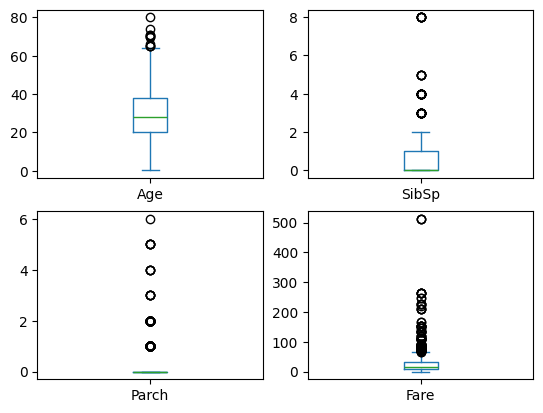

In [164]:
# Let's check the boxplots as well:
fig, axs = plt.subplots(2, 2)

train_data.Age.plot(kind="box", ax=axs[0,0])
train_data.SibSp.plot(kind="box", ax=axs[0,1])
train_data.Parch.plot(kind="box", ax=axs[1,0])
train_data.Fare.plot(kind="box", ax=axs[1,1])

There are outliers but they don't seem to be anomalies requiring correction. The very high Fares can be explained by the fact that  some people reserved multiple cabins for themselves.

BEFORE - Empty value stats: [X_train] : {'Age': 177} / [X_test] : {'Age': 86, 'Fare': 1}
Training data Age Groups after categorization
Age_00_10     64
Age_10_20    115
Age_20_30    230
Age_30_40    155
Age_40_50     86
Age_50_60     42
Age_60_70     17
Age_70_PP      5
Age_XX_XX    177
dtype: int64
Test data Age Groups after categorization
Age_00_10     22
Age_10_20     47
Age_20_30    131
Age_30_40     55
Age_40_50     46
Age_50_60     20
Age_60_70     10
Age_70_PP      1
Age_XX_XX     86
dtype: int64
AFTER - Empty value stats: [X_train] : {} / [X_test] : {}


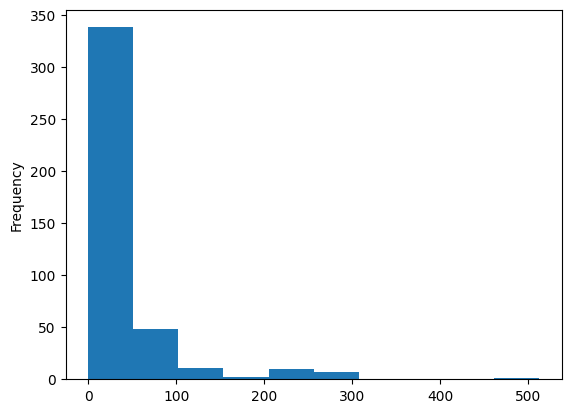

In [ ]:
# Some common preparation needed for using the classifier models.

# Remove from Features :
# - object columns Name, Ticket, Cabin (for sake of simplicity in 1st iteration of model we will ignore these)
# - PassengerId (primary key not useful for modeling)
# - Survived (value to be predicted)
X_train = train_data.drop(columns=["Name", "Ticket", "Cabin", "PassengerId", "Survived"])
X_test  = test_data.drop(columns=["Name", "Ticket", "Cabin", "PassengerId"])
Y_train = train_data.Survived

# For many training and test data, the Feature Age (and also 1 Fare) is missing.
print(f"BEFORE - Empty value stats: [X_train] : {empty_value_stats(X_train)} / [X_test] : {empty_value_stats(X_test)}")

# Most classification models are not able to be trained with data containing missing values. Possible strategies to handle this:
# 1) Replace missing values by mean, median or nearest neighbour.
# 2) Remove records with missing values.
# 3) Only evaluate the 2 models (Decision Tree and Random Forest) of the 8 that can handle missing values.
# 4) Replace the Feature with missing values by groups or bins and add a specific group for the missing values.

# About 20% of the training data have no Age:
# - Applying 1) would probably add bias in the Age (20% of the Age will be aligned with the trend of the remaining 80%).
# - Applying 2) would remove a large part of the training data (about 20%).
# - Applying 3) would limit ourselves to only be able to evaluate 2 out of the 8 binary classification models.
# - Applying 4) seems the best way to go. Also we may assume that the age group (0-10, 10-20, ...) is more important to predict survival then the exact age.

categorize_age(X_train)
categorize_age(X_test)

train_age_group_stats = X_train.filter(like='Age_').sum()
test_age_group_stats = X_test.filter(like='Age_').sum()

print("Training data Age Groups after categorization")
print(train_age_group_stats)

print("Test data Age Groups after categorization")
print(test_age_group_stats)

assert len(X_train) == train_age_group_stats.sum(), \
    f"Mismatch data records ({len(X_train)}) and age group count ({train_age_group_stats.sum()})"

assert len(X_test) == test_age_group_stats.sum(), \
    f"Mismatch test data records ({len(X_test)}) and age group count ({test_age_group_stats.sum()})"

# Replace the single missing Fare by the median (median and not mean because the distribution is skewed to the bottom)
X_test['Fare'].plot(kind = "hist")

X_test = X_test\
    .replace(to_replace={"Fare" : np.nan}, value=X_test.Fare.median())

# For many training and test data, the Feature Age (and also 1 Fare) is missing.
print(f"AFTER - Empty value stats: [X_train] : {empty_value_stats(X_train)} / [X_test] : {empty_value_stats(X_test)}")

## 2. Chosing the model

In [ ]:
# Use GridSearchCV to find the best classifier model and its hyperparameters.

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])

# FIXME how to know which list of hyperparameters to evaluate for each classification model??
params = [
    {
        'classifier' : [LogisticRegression()],
        'classifier__solver': [ 'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga' ]
    },
    {
        'classifier' : [KNeighborsClassifier()],
    },
    {
        'classifier' : [DecisionTreeClassifier()],
    },    
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__n_estimators': [50, 100, 500],
    },
    {
        'classifier' : [GradientBoostingClassifier()],
        'classifier__criterion': ['friedman_mse', 'squared_error'],
    },
    {
        'classifier' : [MLPClassifier()]
    },
    {
        'classifier' : [GaussianNB()]
    },
    {
        'classifier' : [SVC()]
    }        
]

grid_search = GridSearchCV(pipe, params, cv = 5, n_jobs= -1, error_score="raise")
grid_search.fit(X_train, Y_train)

print(f"===> Best score = {grid_search.best_score_} with params = {grid_search.best_params_}")

predicted_values = grid_search.predict(X_test)

predictions = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predicted_values})
predictions.to_csv(WORKING_DIR + '/submission.csv', index=False)

===> Best score = 0.82045069361622 with params = {'classifier': GradientBoostingClassifier(), 'classifier__criterion': 'friedman_mse'}
